# Generate Training Data

### 2D Deterministic Data Generator

In [53]:
WINDOW_SIZE = 10
X_GOAL = 3
GOAL_HEIGHT = 1.25

In [54]:
NUM_XS_START, NUM_YS_START = 5, 5
NUM_XS_END, NUM_YS_END = 5, 15
TIME_STEPS = 150
DECAY = .966
NUM_BETWEEN = 0
NOISE_LEVEL = 0.01
GENERATE_BACKWARDS_SHOTS = False

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


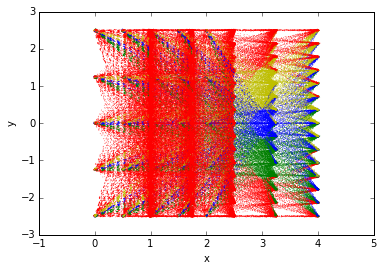

In [55]:
import math
import random

import itertools
from collections import namedtuple

from numpy.random import randn

State = namedtuple('State', ['x', 'y', 'dx', 'dy', 'distance', 'bearing', 'shot_number', 'label'])
World = namedtuple('World', ['goal', 'end'])

def get_label(y):
    """Return the class which y falls in
    
    This amount to returning the index corresponding to the region that y is crossing the plane at
    
    """
    wide_left, left_center, center_right, right_wide = -1.5, -.42, .39, 1.5
    
    if y < wide_left:
        return 0
    elif wide_left <= y < left_center:
        return 1
    elif left_center <= y <= center_right:
        return 2
    elif center_right < y <= right_wide:
        return 3
    elif right_wide < y:
        return 0
    else:
        raise AssertionError(y)

def data_generator(num_xs_start=2, num_ys_start=2, num_xs_end=2, num_ys_end=2, time_steps=10, decay=.8, noise=0):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    num_ends_x : int
    The number of ending points in the x direction you want
    
    num_ends_y : int
    The number of ending points in the y direction you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    noise : float
    the amount of noise present
    
    """
    inc = 1 if not GENERATE_BACKWARDS_SHOTS else 2
    
    xs_start, ys_start = np.linspace(0, 2, num_xs_start), np.linspace(-2.5, 2.5, num_ys_start)
    starts = itertools.product(xs_start, ys_start)
    
    # Create grid of end points
    xs_end, ys_end = np.linspace(1, 4, num_xs_end), np.linspace(-2.5, 2.5, num_ys_end)
    ends = itertools.product(xs_end, ys_end)
    shot_number = 0
    for (x_start, y_start), (x_end, y_end) in itertools.product(starts, ends):
        if x_end < X_GOAL:
            label = 0
        else:
            # Draw a line and see where the ball intersects
            slope = (y_end-y_start) / (x_end-x_start)
            y = slope*(X_GOAL-x_start) + y_start
            label = get_label(y)
        
        # Starting velocities to reach the destination
        c = (1-decay) / (1-decay**(time_steps-1))
        dx_start = c * (x_end-x_start)
        dy_start = c * (y_end-y_start)

        # Calculate how far you've traveled from the start at each time_step
        decays = np.array([decay**pow for pow in range(time_steps)])

        # Velocity at each time step
        x_velocities = decays * dx_start
        y_velocities = decays * dy_start

        # Distance traveled at each time step
        x_deltas = np.cumsum(x_velocities)
        y_deltas = np.cumsum(y_velocities)

        # Compute the actual points given deltas
        x_positions = x_start + x_deltas
        x_positions = np.append([x_start], x_positions[:-1])
        y_positions = y_start + y_deltas
        y_positions = np.append([y_start], y_positions[:-1])
        
        # Yield the points one by one
        for x, y, dx, dy in zip(x_positions, y_positions, x_velocities, y_velocities):
            # Noise
            x += noise*np.random.randn()
            y += noise*np.random.randn()
            
            # Compute distance and bearing exactly from noisy estimates
            distance, bearing = np.sqrt((x-X_GOAL)**2 + (y-0)**2), math.atan(y/(X_GOAL-x)) if x else 0
            
            yield State(x, y, dx, dy, distance, bearing, shot_number, label)
            
        if GENERATE_BACKWARDS_SHOTS:
            for x, y, dx, dy in zip(reversed(x_positions), reversed(y_positions),
                                    reversed([0]+x_velocities[:-1]), reversed([0]+y_velocities[:-1])):
                yield State(x, y, -dx, -dy, distance, bearing, shot_number+1, 0)
            
        shot_number += inc

# Generate shot data
data_points = data_generator(num_xs_start=NUM_XS_START, num_ys_start=NUM_YS_START,
                             num_xs_end=NUM_XS_END, num_ys_end=NUM_YS_END,
                             time_steps=TIME_STEPS, decay=DECAY, noise=NOISE_LEVEL)
data_points = list(data_points)

# Plot it
df = pd.DataFrame(data_points, columns=State._fields)
labels = df['label']
colormap = np.array(['r', 'g', 'b', 'y'])
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, width=.0022)

### Class Ratio

In [56]:
df.groupby('label').size()

label
0    202350
1     28050
2     22500
3     28350
dtype: int64

### Filter Away Points out of Goalie's Field of View

label
0    179940
1      8460
2      6427
3      8524
dtype: int64

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


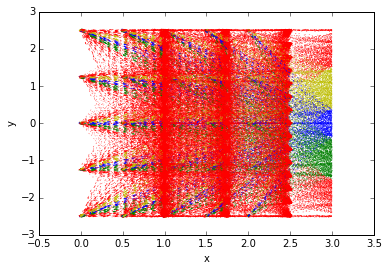

In [57]:
data_points = [data_point for data_point in data_points if not data_point.x > X_GOAL]

df = pd.DataFrame(data_points, columns=State._fields)

# Plot it
labels = df['label']
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)
 
df.groupby('label').size()

### Restore Class Balance

In [58]:
def undersample(df, bad_label, good_label, ratio=1.0):
    """Keep throwing out shots with label2 until we have more shots with label1"""

    while True:
        sizes = df.groupby('label').size()
        if ratio*sizes[good_label] > sizes[bad_label]:
            break

        # Choose an unlucky miss to go
        misses = df[df.label == bad_label]
        shot_numbers = misses.shot_number.unique()
        unlucky_shot = np.random.choice(shot_numbers, 1)[0]
        mask = (df.label == bad_label) & (df.shot_number == unlucky_shot)

        df = df[~mask]
        
    return df
    
df.groupby('label').size()

label
0    179940
1      8460
2      6427
3      8524
dtype: int64

### Undersample Shots

In [59]:
df = undersample(df, 1, 2)
df = undersample(df, 3, 2)

### Undersample Misses

In [60]:
df = undersample(df, 0, 2, ratio=3.)

### Plot Filtered Shots

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


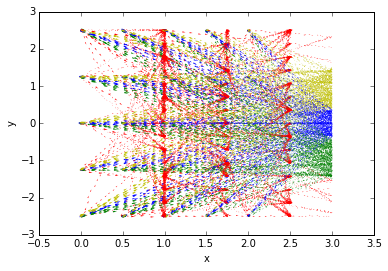

In [61]:
labels = df['label']
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

In [62]:
df.groupby('label').size()

label
0    19256
1     6386
2     6427
3     6403
dtype: int64

### Helper Functions

In [63]:
def windowize(X, window_size):
    """Takes a 1darray and windowizes it
    
    Parameters
    ----------
    X : numpy array
    the data you want to windowize
    
    window_size : int
    the size of the window you want
    
    """
    for i in range(window_size-1):
        yield X[i:-(window_size-i-1)]

    yield X[window_size-1:]

def windowize_wrapper(col_name, group):
    """Windowizes a pandas groupby object
    
    - Extract the column specified by col_name
    - Pass it to windowize()
    - Stack the result and return
    
    """
    positions = np.array(group[col_name])
    windowed = list(windowize(positions, WINDOW_SIZE))
    
    return np.vstack(windowed)

### Windowize Input

In [64]:
grouped = df.groupby('shot_number')

In [65]:
from functools import partial

# x
wr = partial(windowize_wrapper, 'x')
xs = np.hstack(grouped.apply(wr))

# y
wr = partial(windowize_wrapper, 'y')
ys = np.hstack(grouped.apply(wr))

# dx
wr = partial(windowize_wrapper, 'dx')
dxs = np.hstack(grouped.apply(wr))

# dy
wr = partial(windowize_wrapper, 'dy')
dys = np.hstack(grouped.apply(wr))

# distance
wr = partial(windowize_wrapper, 'distance')
distances = np.hstack(grouped.apply(wr))

# bearing
wr = partial(windowize_wrapper, 'bearing')
bearings = np.hstack(grouped.apply(wr))

stacked = np.vstack([xs] + [ys] + [dxs] + [dys] + [distances] + [bearings])
df1 = pd.DataFrame(stacked.T, columns=[
        *['x{}' .format(i) for i in range(WINDOW_SIZE)],
        *['y{}' .format(i) for i in range(WINDOW_SIZE)],
        *['dx{}'.format(i) for i in range(WINDOW_SIZE)],
        *['dy{}'.format(i) for i in range(WINDOW_SIZE)],
        *['dist{}'.format(i) for i in range(WINDOW_SIZE)],
        *['theta{}'.format(i) for i in range(WINDOW_SIZE)]])

# Compute average positions, velocities, distances, and bearings for future plotting
df1['x_avg'] = df1.ix[:, 'x0':'x{}'.format(WINDOW_SIZE-1)].mean(axis=1)
df1['y_avg'] = df1.ix[:, 'y0':'y{}'.format(WINDOW_SIZE-1)].mean(axis=1)

df1['dx_avg'] = df1.ix[:, 'dx0':'dx{}'.format(WINDOW_SIZE-1)].mean(axis=1)
df1['dy_avg'] = df1.ix[:, 'dy0':'dy{}'.format(WINDOW_SIZE-1)].mean(axis=1)

df1['dist_avg'] = df1.ix[:, 'dist0':'dist{}'.format(WINDOW_SIZE-1)].mean(axis=1)
df1['theta_avg'] = df1.ix[:, 'theta0':'theta{}'.format(WINDOW_SIZE-1)].mean(axis=1)

# Shot number
wr = partial(windowize_wrapper, 'shot_number')
shot_numbers = np.hstack([shot_sequence.mean(axis=0) for shot_sequence in grouped.apply(wr)])

# Labels
wr = partial(windowize_wrapper, 'label')
labels = np.hstack([label_sequence.mean(axis=0) for label_sequence in grouped.apply(wr)])

stacked = np.vstack([shot_numbers] + [labels])
df2 = pd.DataFrame(stacked.T, columns=['shot_number', 'label'])

df = pd.concat([df1, df2], axis=1)

In [66]:
df.groupby('label').size()

label
0    18014
1     5099
2     5077
3     5116
dtype: int64

### Undersample Again!

By their very nature, short shots are going to have a lot more data points than actual shots, which is going to result in a lot more misses than shots! Hence we do the same thing as above and keep removing missed shots until we have more made shots than missed shots.

In [67]:
df = undersample(df, 0, 1)
df = undersample(df, 0, 3)
df = undersample(df, 0, 2, ratio=3.)

### Plot the Shots that Made It!

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  from ipykernel import kernelapp as app
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  app.launch_new_instance()


/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


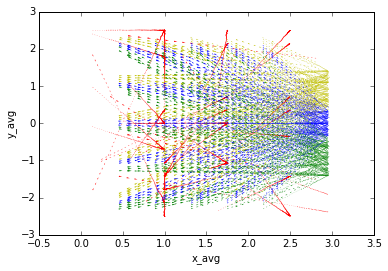

In [68]:
labels = df['label']
axes = df.plot(kind='scatter', x='x_avg', y='y_avg', c=colormap[labels], s=0)
axes.quiver(df['x_avg'], df['y_avg'], df['dx_avg'], df['dy_avg'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

In [69]:
df.groupby('label').size()

label
0    4979
1    5099
2    5077
3    5116
dtype: int64

In [70]:
shots = {'df': df, 'window_size': WINDOW_SIZE}

%store shots

Stored 'shots' (dict)
